In [330]:
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import geopandas as gpd
import matplotlib
import re
from bixin import predict
from tqdm.auto import tqdm
import numpy as np
from matplotlib.ticker import PercentFormatter

# Preparation

In [300]:
tqdm.pandas()
sns.set_theme(style="whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['axes.unicode_minus'] = False

# Load Data

In [301]:
# Load election-related video comments data
election_file_paths = [
    '【深度】特朗普胜选！美国_评论.csv',
    '川普以277票大胜哈里斯_评论.csv',
    '特朗普宣布胜选_哔哩哔哩_评论.csv',
    '特朗普胜选后，拜登笑得比_评论.csv',
    '败选后再胜选，这复仇的滋_评论.csv'
]

dfs = [pd.read_csv(fp) for fp in election_file_paths]
df_election = pd.concat(dfs, ignore_index=True)

# Load tariff-related video comments data
df_tariff = pd.read_csv("Tariff_comments.csv")

# Column name translation mapping
column_translation = {
    '序号': 'Index',
    '上级评论ID': 'Parent Comment ID',
    '评论ID': 'Comment ID',
    '评论属性': 'Comment Type',
    '用户ID': 'User ID',
    '用户名': 'Username',
    '用户等级': 'User Level',
    '性别': 'Gender',
    '评论内容': 'Comment Text',
    '评论时间': 'Comment Time',
    '回复数': 'Reply Count',
    '点赞数': 'Like Count',
    '个性签名': 'User Signature',
    'IP属地': 'IP Location',
    '是否是大会员': 'VIP Status',
    '头像': 'Avatar URL'
}

# Rename columns
df_election.rename(columns=column_translation, inplace=True)
df_tariff.rename(columns=column_translation, inplace=True)

# Remove repeating comments
df_election = df_election.drop_duplicates(subset=['Comment Text'])
df_tariff = df_tariff.drop_duplicates(subset=['Comment Text'])


# Remove emojis
def remove_brackets(text):
    return re.sub(r'\[.*?\]', '', text)


# Apply it to your comments
df_election['Comment Text'] = df_election['Comment Text'].astype(str).apply(remove_brackets)
df_tariff['Comment Text'] = df_tariff['Comment Text'].astype(str).apply(remove_brackets)

# After removing emojis, drop empty comments
df_election = df_election[df_election['Comment Text'].str.strip() != '']
df_tariff = df_tariff[df_tariff['Comment Text'].str.strip() != '']

# Daily comment counts

date
2024-11-03      329
2024-11-04      262
2024-11-05       65
2024-11-06    13779
2024-11-07     4108
              ...  
2025-04-24       46
2025-04-25       79
2025-04-26       62
2025-04-27       36
2025-04-28        4
Length: 137, dtype: int64


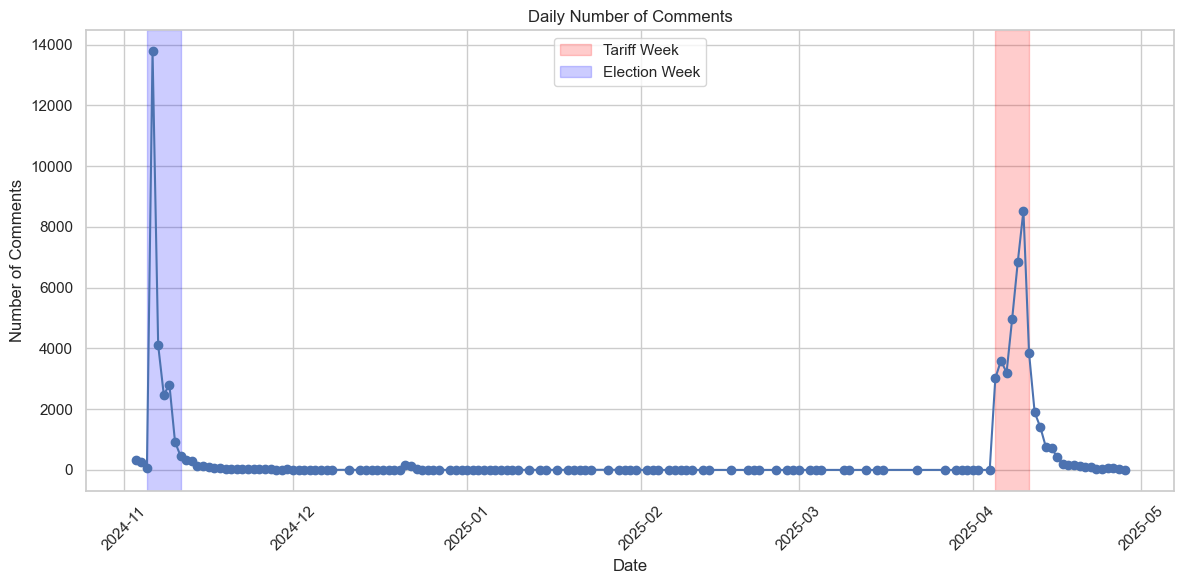

In [305]:
# Convert 'Comment Time' to datetime format
df_combined = pd.concat([df_tariff, df_election], ignore_index=True)
df_combined['Comment Time'] = pd.to_datetime(df_combined['Comment Time'], errors='coerce')

# Drop rows where 'Comment Time' could not be parsed
df_combined = df_combined.dropna(subset=['Comment Time'])

# Extract the date part only (year-month-day)
df_combined['date'] = df_combined['Comment Time'].dt.date

# Group by date and count the number of comments
daily_comment_counts = df_combined.groupby('date').size()
print(daily_comment_counts)

# Plot the daily comment counts
plt.figure(figsize=(12, 6))
plt.plot(daily_comment_counts.index, daily_comment_counts.values, marker='o')
plt.title('Daily Number of Comments')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.grid(True)
plt.xticks(rotation=45)
plt.axvspan(pd.to_datetime('2025-04-05'), pd.to_datetime('2025-04-11'), color='red', alpha=0.2, label='Tariff Week')
plt.axvspan(pd.to_datetime('2024-11-05'), pd.to_datetime('2024-11-11'), color='blue', alpha=0.2, label='Election Week')

plt.tight_layout()
plt.legend()
plt.show()

# Top 5 comments with most likes

## Top 5 comments with most likes in election videos

In [307]:
top5_likes_election = df_election.sort_values(by='Like Count', ascending=False).head(5)
top5_likes_election[['Username', 'Comment Text', 'Like Count', 'Comment Time']]

,Username,Comment Text,Like Count,Comment Time
6270,写张卷子冷静下-,假如你是李华，你的朋友哈里斯告诉你，她输掉了大选，心情非常沮丧，你要写一封信安慰一下她。要求...,36106,2024-11-06 15:37:37
9652,雨未歇べ,埃隆马斯克这种金牌辅助，收购推特真是神助攻，确实厉害，首富的眼光和胆识,24400,2024-11-06 11:04:06
24141,打不过就喷口水,可能很多人忘记了，拜登虽然是个老人，但他是冷战思维的政治家，谁得罪他，他自然而然就会站在得罪...,19471,2024-11-08 15:07:40
8780,-_-狐尼克-_-,那颗子弹偏移了1㎜。命运的齿轮改变了，不知道历史会怎样谱写。\n只希望中华人民共和国 繁荣富...,13504,2024-11-06 11:42:24
5559,奶油浓汤ww,摇摆州7:0，这是致敬啊,12773,2024-11-07 03:14:26


## Top 5 comments with most likes in tariff videos

In [308]:
top5_likes_tariff = df_tariff.sort_values(by='Like Count', ascending=False).head(5)
top5_likes_tariff[['Username', 'Comment Text', 'Like Count', 'Comment Time']]

,Username,Comment Text,Like Count,Comment Time
12052,四月阿-,今天自己洗车省了40块钱，下午打开股票账户一看车没了,36335,2025-04-07 11:17:19
24152,大地怒吼2,很多MAGA是真的不知道关税最终是由自己承担的,15922,2025-04-05 11:12:27
14056,282364786,特朗普赌场都能经营倒闭 到这真绷不住了,13459,2025-04-06 10:45:20
12367,深圳全球速递,在川普的关税中有个叫做赫德岛和麦克唐纳群岛的国家，川普对他收取了10%的关税 但是该岛是个无...,9987,2025-04-07 08:32:06
11947,39_Z01,顶级回旋镖,8843,2025-04-07 12:54:19


# Sentiment Analysis

## Calculate sentiment scores of (top-level) comments

In [309]:
# Filter for top-level comments (where 'Parent Comment ID' is 0 or missing)
top_level_comments_election = df_election[df_election['Parent Comment ID'] == 0].copy()
top_level_comments_tariff = df_tariff[df_tariff['Parent Comment ID'] == 0].copy()

# Calculate sentiment score for each comment
top_level_comments_tariff.loc[:, 'sentiment_score'] = top_level_comments_tariff['Comment Text'].apply(
    lambda x: predict(x))
top_level_comments_election.loc[:, 'sentiment_score'] = top_level_comments_election['Comment Text'].apply(
    lambda x: predict(x))

## Plot the sentiment score distributions 

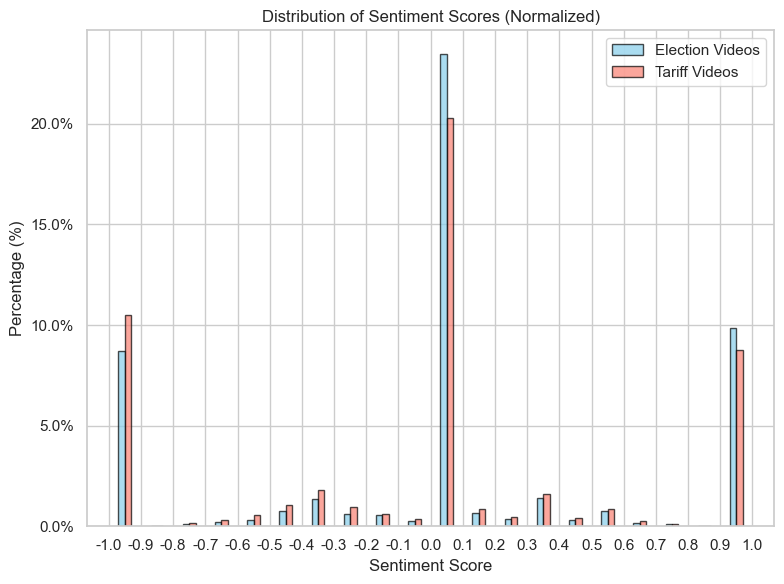

In [335]:
# Define consistent bin edges and centers
bins = np.linspace(-1, 1, 21)  # 20 bins between 0 and 1
centers = (bins[:-1] + bins[1:]) / 2
bin_width = (bins[1] - bins[0]) / 2

# Compute normalized histogram densities
election_density, _ = np.histogram(top_level_comments_election['sentiment_score'], bins=bins, density=True)
tariff_density, _ = np.histogram(top_level_comments_tariff['sentiment_score'], bins=bins, density=True)

# Convert densities to percentages
election_pct = election_density * bin_width * 100
tariff_pct = tariff_density * bin_width * 100

# Set bar width and offset for visual separation
bar_width = bin_width * 0.4
offset = bar_width / 2

# Plot side-by-side histograms
plt.figure(figsize=(8, 6))
plt.bar(centers - offset, election_pct, width=bar_width, color='skyblue', alpha=0.7,
        label='Election Videos', edgecolor='black', align='center')
plt.bar(centers + offset, tariff_pct, width=bar_width, color='salmon', alpha=0.7,
        label='Tariff Videos', edgecolor='black', align='center')

# Add labels and formatting
plt.xlabel('Sentiment Score')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Sentiment Scores (Normalized)')
plt.legend()
plt.xticks(bins)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter())

plt.tight_layout()
plt.show()

## Most positive ten comments

In [338]:
# Get the top 10 comments with the highest sentiment scores
top5_sentiment_election = top_level_comments_election.sort_values(by='sentiment_score', ascending=False).head(5)

# Display results
print("Top 10 Most Positive Comments in Election Videos:")
top5_sentiment_election[['Username', 'Comment Text', 'sentiment_score']]

Top 10 Most Positive Comments in Election Videos:


,Username,Comment Text,sentiment_score
25509,当马克虫变成戴高龙,川宝回归，我的快乐源泉又回来了~,1.0
16796,三斤橘子三斤榴莲,简中，清理大师，上线。断狗粮，替清朗。,1.0
4175,大翔队王多鱼,彦祖，把哈哈哈哈哈姐当选的视频也发一下吧！我想体验下平行时空,1.0
24288,金钱豹的地瓜,为什么感觉拜登前后状态就是俩人一样之前像老年痴呆，现在看着怎么精神这么多？,1.0
7748,风临山海间,特朗普二度当选总统，入主白宫，强势回归，我愿称之为美熹宗,1.0


In [340]:
# Get the top 10 comments with the highest sentiment scores
top5_sentiment_tariff = top_level_comments_tariff.sort_values(by='sentiment_score', ascending=False).head(5)

# Display results
print("Top 10 Most Positive Comments in Tariff Videos:")
top5_sentiment_tariff[['Username', 'Comment Text', 'sentiment_score']]

Top 10 Most Positive Comments in Tariff Videos:


,Username,Comment Text,sentiment_score
18758,_Panda,难怪，要乌克兰稀土资源,1.0
30015,弥留之境,好难啊，听个热闹还要查典故，有没有牛逼大点的人，直述一下讲的大概是啥,1.0
7608,love_hippo,讲的非常好，比一些炒股的金融区up讲的未来展望和布局更加合理且站的住脚,1.0
29870,超龄佬沐,啥时候日本成小国了虽然地方确实不大,1.0
7617,椰_子酱,打持久战我们是很有经验的,1.0


## Most negative ten comments

In [341]:
# Get the top 10 comments with the lowest sentiment scores
bottom5_sentiment_election = top_level_comments_election.sort_values(by='sentiment_score', ascending=True).head(5)

print("\nTop 10 Most Negative Comments in Election Videos:")
bottom5_sentiment_election[['Username', 'Comment Text', 'sentiment_score']]


Top 10 Most Negative Comments in Election Videos:


,Username,Comment Text,sentiment_score
0,们原有自己的达虾,禁止堕胎逆天,-1.0
21361,逆世独行,祸水东引，全身而退，6 啊,-1.0
6513,二刺螈n,我嘞个蓝色草原上的不死巨蟒。,-1.0
21353,友哈相赫,以前的舆论不都是骂登子，嘲笑登子吗，怎么他现在快滚蛋了，风评反而好起来了？,-1.0
6520,白桦林深处的向日葵,这贸易保护主义又要加深了,-1.0


In [342]:
# Get the top 10 comments with the lowest sentiment scores
bottom5_sentiment_tariff = top_level_comments_tariff.sort_values(by='sentiment_score', ascending=True).head(5)

print("\nTop 10 Most Negative Comments in Tariff Videos:")
bottom5_sentiment_tariff[['Username', 'Comment Text', 'sentiment_score']]


Top 10 Most Negative Comments in Tariff Videos:


,Username,Comment Text,sentiment_score
18891,奔跑的紫貂,连加拿大都反击了，何况别的国家,-1.0
6602,狸歌大魔王,斗争性是矛盾同一性的前提,-1.0
6603,希望每个人都加油,加加加到厌倦,-1.0
6605,黔兔丨随風,美国跟西方经济学总得死一个吧,-1.0
30488,陆地小龙虾,今日割五城，明日割十城，然后得一夕安寝。起视四境，而秦兵又至矣。然则诸侯之地有限，暴秦之欲无...,-1.0


## Sentiment across provinces

In [351]:
# Remove comments without IP information
top_level_comments_election = top_level_comments_election.dropna(subset=['IP Location'])
top_level_comments_tariff = top_level_comments_tariff.dropna(subset=['IP Location'])

# Remove comments without sentiment score if necessary
top_level_comments_election = top_level_comments_election.dropna(subset=['sentiment_score'])
top_level_comments_tariff = top_level_comments_tariff.dropna(subset=['sentiment_score'])

# Standardize province names
province_mapping = {
    '北京': 'Beijing', '天津': 'Tianjin', '上海': 'Shanghai', '重庆': 'Chongqing',
    '河北': 'Hebei', '山西': 'Shanxi', '辽宁': 'Liaoning', '吉林': 'Jilin', '黑龙江': 'Heilongjiang',
    '江苏': 'Jiangsu', '浙江': 'Zhejiang', '安徽': 'Anhui', '福建': 'Fujian', '江西': 'Jiangxi',
    '山东': 'Shandong', '河南': 'Henan', '湖北': 'Hubei', '湖南': 'Hunan',
    '广东': 'Guangdong', '海南': 'Hainan', '四川': 'Sichuan', '贵州': 'Guizhou', '云南': 'Yunnan',
    '陕西': 'Shaanxi', '甘肃': 'Gansu', '青海': 'Qinghai',
    '中国台湾': 'Taiwan', '广西': 'Guangxi', '内蒙古': 'Inner Mongolia', '宁夏': 'Ningxia',
    '新疆': 'Xinjiang', '西藏': 'Tibet', '中国香港': 'Hong Kong', '中国澳门': 'Macau'
}

top_level_comments_election['province'] = top_level_comments_election['IP Location'].map(
    lambda x: next((full_name for short_name, full_name in province_mapping.items() if short_name in str(x)), None))
top_level_comments_election = top_level_comments_election.dropna(subset=['province'])

top_level_comments_tariff['province'] = top_level_comments_tariff['IP Location'].map(
    lambda x: next((full_name for short_name, full_name in province_mapping.items() if short_name in str(x)), None))
top_level_comments = top_level_comments_tariff.dropna(subset=['province'])


# Group by IP and calculate count and mean sentiment score
province_summary_election = top_level_comments_election.groupby('province').agg(
    comment_count=('Comment Text', 'count'),
    average_sentiment_election=('sentiment_score', 'mean')
).reset_index()

province_summary_tariff = top_level_comments_tariff.groupby('province').agg(
    comment_count=('Comment Text', 'count'),
    average_sentiment_tariff=('sentiment_score', 'mean')
).reset_index()

province_summary_election.head(5)
province_summary_tariff.head(5)

# # Extract top 5 provinces with the highest average sentiment
# top5_sentiment = province_summary_election.sort_values(by='average_sentiment', ascending=False).head(5)
#
# # Extract bottom 5 provinces with the lowest average sentiment
# bottom5_sentiment = province_summary_election.sort_values(by='average_sentiment', ascending=True).head(5)
#
# # Display results
# print("Top 5 Provinces by Average Sentiment Score:")
# top5_sentiment[['province', 'comment_count', 'average_sentiment']]
#
# print("\nBottom 5 Provinces by Average Sentiment Score:")
# bottom5_sentiment[['province', 'comment_count', 'average_sentiment']]

,province,comment_count,average_sentiment_tariff
0,Anhui,422,-0.011256
1,Beijing,715,0.001133
2,Chongqing,302,-0.066490
3,Fujian,446,-0.073072
4,Gansu,93,-0.082688


## Visulization of comment counts and sentiment scores across provinces

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


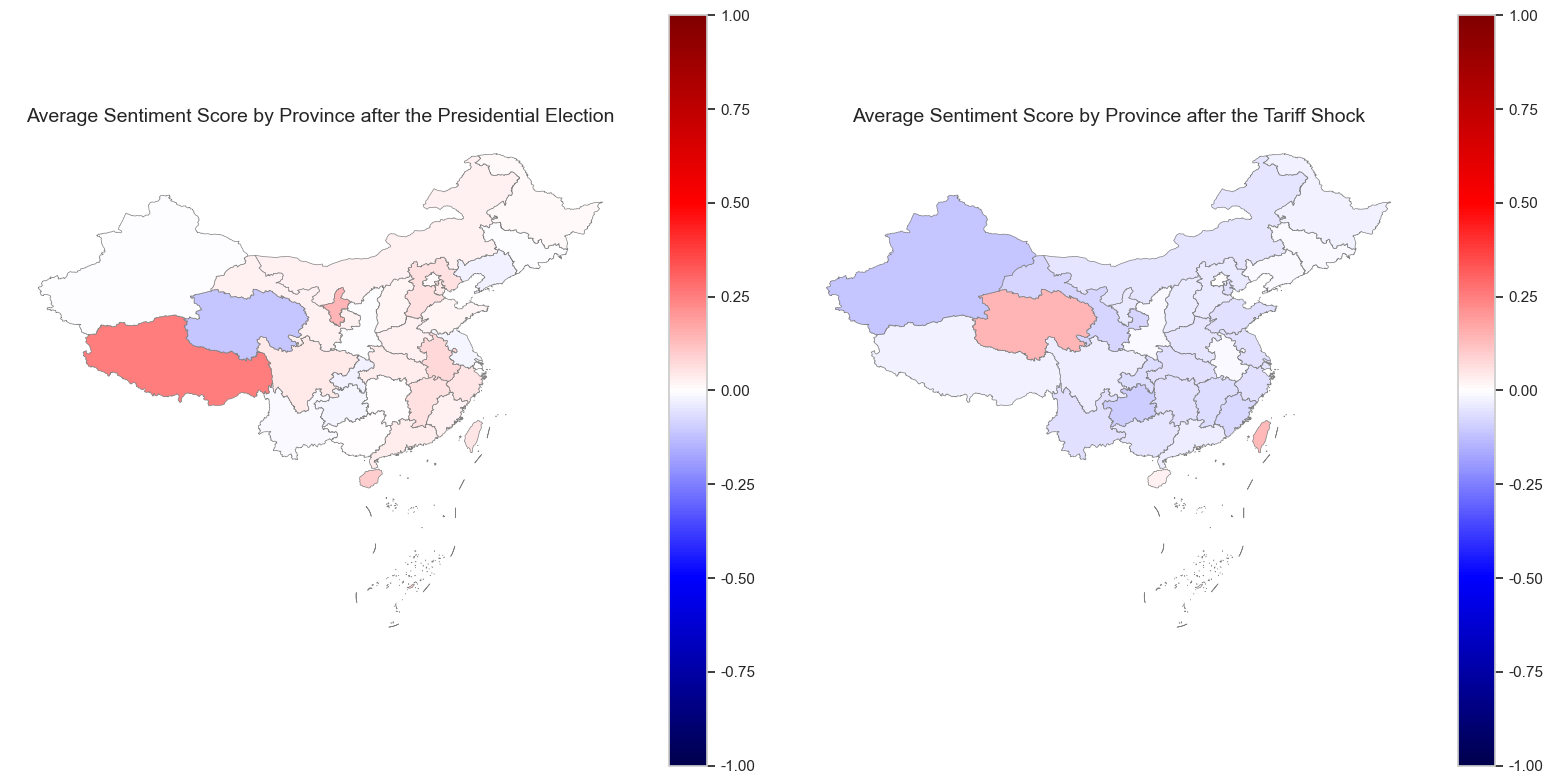

In [380]:
# Load China map
geojson_path = '100000_full.json'
china_map = gpd.read_file(geojson_path)

# Mapping from Chinese province names to English
chinese_to_english = {
    '北京市': 'Beijing', '天津市': 'Tianjin', '上海市': 'Shanghai', '重庆市': 'Chongqing',
    '河北省': 'Hebei', '山西省': 'Shanxi', '辽宁省': 'Liaoning', '吉林省': 'Jilin', '黑龙江省': 'Heilongjiang',
    '江苏省': 'Jiangsu', '浙江省': 'Zhejiang', '安徽省': 'Anhui', '福建省': 'Fujian', '江西省': 'Jiangxi',
    '山东省': 'Shandong', '河南省': 'Henan', '湖北省': 'Hubei', '湖南省': 'Hunan',
    '广东省': 'Guangdong', '海南省': 'Hainan', '四川省': 'Sichuan', '贵州省': 'Guizhou', '云南省': 'Yunnan',
    '陕西省': 'Shaanxi', '甘肃省': 'Gansu', '青海省': 'Qinghai',
    '台湾省': 'Taiwan', '广西壮族自治区': 'Guangxi', '内蒙古自治区': 'Inner Mongolia',
    '宁夏回族自治区': 'Ningxia', '新疆维吾尔自治区': 'Xinjiang', '西藏自治区': 'Tibet',
    '香港特别行政区': 'Hong Kong', '澳门特别行政区': 'Macau'
}

# Add a new column with English province names
china_map['province'] = china_map['name'].map(chinese_to_english)

# Merge data
merged = china_map.merge(province_summary_election, how='left', left_on='province', right_on='province')
merged = merged.merge(province_summary_tariff, how='left', left_on='province', right_on='province')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Map 1: Comment Count map
merged.plot(
    column='average_sentiment_election',
    cmap='seismic',  # 或 'bwr', 'PiYG' 等
    linewidth=0.5,
    edgecolor='0.5',
    legend=True,
    ax=axes[0],
    missing_kwds={"color": "lightgrey"},
    vmin=-1,
    vmax=1
)
axes[0].set_title('Average Sentiment Score by Province after the Presidential Election', fontsize=14)
axes[0].axis('off')

# Map 2: Average Sentiment map
merged.plot(
    column='average_sentiment_tariff',
    cmap='seismic',  # 或 'bwr', 'PiYG' 等
    linewidth=0.5,
    edgecolor='0.5',
    legend=True,
    ax=axes[1],
    missing_kwds={"color": "lightgrey"},
    vmin=-1,
    vmax=1
)
axes[1].set_title('Average Sentiment Score by Province after the Tariff Shock', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Exports to US vs. Sentiment Scores across Provinces

0    414.91
1    408.95
2    382.65
3    297.02
4     45.88
Name: Export_to_US (100M RMB), dtype: float64


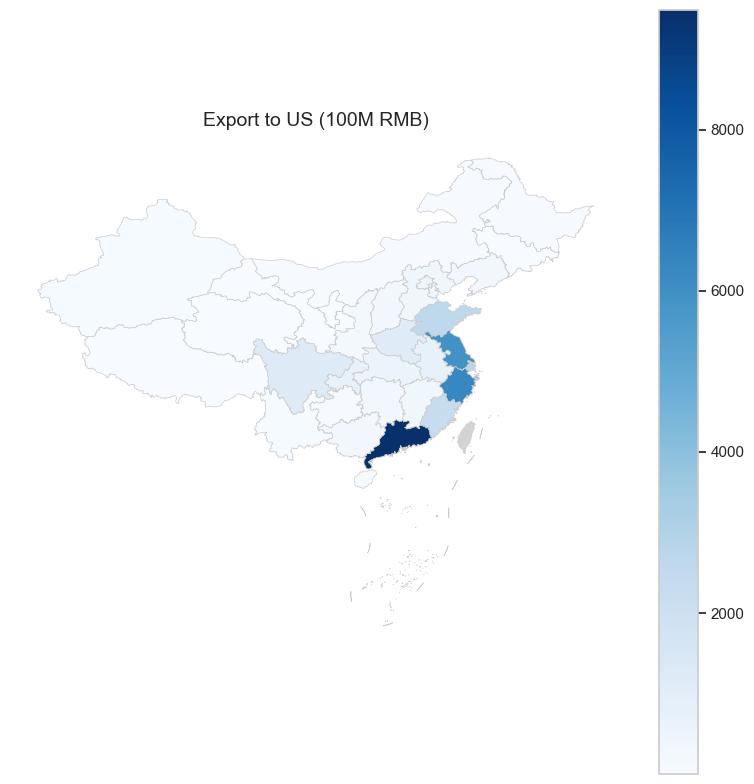

In [354]:
# Provincial Exports to US
export = [
    ['Guangdong', 9487.76], ['Zhejiang', 6316.42], ['Jiangsu', 5904.26], ['Shanghai', 2772.58], ['Shandong', 2623.51],
    ['Fujian', 2323.05], ['Sichuan', 1219.75], ['Henan', 1157.08], ['Anhui', 753.85], ['Chongqing', 715.04],
    ['Hubei', 590.87], ['Beijing', 414.91], ['Tianjin', 408.95], ['Hebei', 382.65], ['Jiangxi', 380.47],
    ['Liaoning', 318.18], ['Hunan', 314.56], ['Shanxi', 297.02], ['Guangxi', 287.12], ['Shaanxi', 194.72],
    ['Yunnan', 106.68], ['Xinjiang', 102.40], ['Hainan', 58.07], ['Inner Mongolia', 45.88], ['Heilongjiang', 40.84],
    ['Guizhou', 38.18], ['Jilin', 28.79], ['Tibet', 19.92], ['Ningxia', 19.55], ['Gansu', 12.04], ['Qinghai', 0.97]
]

export = pd.DataFrame(export, columns=['province', 'Export_to_US (100M RMB)'])

# Merge export data into provincial summary
merged = merged.merge(export, on='province', how='left')
print(merged["Export_to_US (100M RMB)"].head(5))

# Plot maps
fig, ax = plt.subplots(figsize=(8, 8))  # only one subplot now

merged.plot(
    column='Export_to_US (100M RMB)',
    cmap='Blues',
    linewidth=0.5,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey"}
)

ax.set_title('Export to US (100M RMB)', fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()

In [355]:
# Correlation coefficient between sentiment scores and exports to US across provinces
correlation = merged[['average_sentiment_election', 'Export_to_US (100M RMB)']].dropna().corr().iloc[0, 1]
print("Right after the election, the correlation coefficient between sentiment scores and exports to US is " + str(correlation))

Right after the election, the correlation coefficient between sentiment scores and exports to US is -0.0415747373858546


In [356]:
# Correlation coefficient between sentiment scores and exports to US across provinces
correlation = merged[['average_sentiment_tariff', 'Export_to_US (100M RMB)']].dropna().corr().iloc[0, 1]
print("Right after the tariff shock, the correlation coefficient between sentiment scores and exports to US is " + str(correlation))

Right after the tariff shock, the correlation coefficient between sentiment scores and exports to US is -0.11125701233645979


## Comment counts and sentiment by gender

In [357]:
# Define the mapping from Chinese to English for gender
gender_mapping = {
    '保密': 'Secret',
    '男': 'Male',
    '女': 'Female'
}

# Apply the mapping to the Gender column
top_level_comments_election['Gender'] = top_level_comments_election['Gender'].map(gender_mapping)
top_level_comments_tariff['Gender'] = top_level_comments_tariff['Gender'].map(gender_mapping)

gender_summary_election = top_level_comments_election.groupby('Gender').agg(
    comment_count=('Comment Text', 'count'),
    average_sentiment=('sentiment_score', 'mean')
).reset_index()

gender_summary_tariff = top_level_comments_tariff.groupby('Gender').agg(
    comment_count=('Comment Text', 'count'),
    average_sentiment=('sentiment_score', 'mean')
).reset_index()

# Display results
print("The distribution of comment counts and sentiment scores by gender (right after the election)")
gender_summary_election

The distribution of comment counts and sentiment scores by gender (right after the election)


,Gender,comment_count,average_sentiment
0,Female,611,-0.004124
1,Male,4250,0.028645
2,Secret,7514,0.020129


In [358]:
print("The distribution of comment counts and sentiment scores by gender (right after the tariff shock)")
gender_summary_tariff

The distribution of comment counts and sentiment scores by gender (right after the tariff shock)


,Gender,comment_count,average_sentiment
0,Female,865,-0.033538
1,Male,4547,-0.044036
2,Secret,8967,-0.041378


# Sentiment analysis for comments with "Trump"

In [360]:
trump_related_comments_election = top_level_comments_election[
    top_level_comments_election['Comment Text'].astype(str).str.contains('川普' or '特朗普')].copy()

trump_related_comments_tariff = top_level_comments_tariff[
    top_level_comments_tariff['Comment Text'].astype(str).str.contains('川普' or '特朗普')].copy()

# Calculate and display the results
average_sentiment_election = trump_related_comments_election['sentiment_score'].mean()
average_sentiment_tariff = trump_related_comments_tariff['sentiment_score'].mean()


print(f"Right after the election, the average sentiment score for comments mentioning 'Trump' : {average_sentiment_election:.4f}")
print(f"Right after the tariff shock, the average sentiment score for comments mentioning 'Trump': {average_sentiment_tariff:.4f}")

Right after the election, the average sentiment score for comments mentioning 'Trump' : 0.0871
Right after the tariff shock, the average sentiment score for comments mentioning 'Trump': -0.0765


# Sentiment analysis for comments with "Korea"

In [361]:
korea_related_comments_election = top_level_comments_election[
    top_level_comments_election['Comment Text'].astype(str).str.contains('韩国')].copy()

korea_related_comments_tariff = top_level_comments_tariff[
    top_level_comments_tariff['Comment Text'].astype(str).str.contains('韩国')].copy()

# Calculate and display the results
average_sentiment_election = korea_related_comments_election['sentiment_score'].mean()
average_sentiment_tariff = korea_related_comments_tariff['sentiment_score'].mean()


print(f"Right after the election, the average sentiment score for comments mentioning 'Korea' : {average_sentiment_election:.4f}")
print(f"Right after the tariff shock, the average sentiment score for comments mentioning 'Korea': {average_sentiment_tariff:.4f}")

Right after the election, the average sentiment score for comments mentioning 'Korea' : 0.0227
Right after the tariff shock, the average sentiment score for comments mentioning 'Korea': 0.2567


# Sentiment analysis for comments with "Trade"

In [362]:
trade_related_comments_election = top_level_comments_election[
    top_level_comments_election['Comment Text'].astype(str).str.contains('贸易' or '关税')].copy()

trade_related_comments_tariff = top_level_comments_tariff[
    top_level_comments_tariff['Comment Text'].astype(str).str.contains('贸易' or '关税')].copy()

# Calculate and display the results
average_sentiment_election = trade_related_comments_election['sentiment_score'].mean()
average_sentiment_tariff = trade_related_comments_tariff['sentiment_score'].mean()


print(f"Right after the election, the average sentiment score for comments mentioning 'Trade' or 'Tariff': {average_sentiment_election:.4f}")
print(f"Right after the tariff shock, the average sentiment score for comments mentioning 'Trade' or 'Tariff': {average_sentiment_tariff:.4f}")

Right after the election, the average sentiment score for comments mentioning 'Trade' or 'Tariff': -0.0512
Right after the tariff shock, the average sentiment score for comments mentioning 'Trade' or 'Tariff': -0.0882


# Word cloud

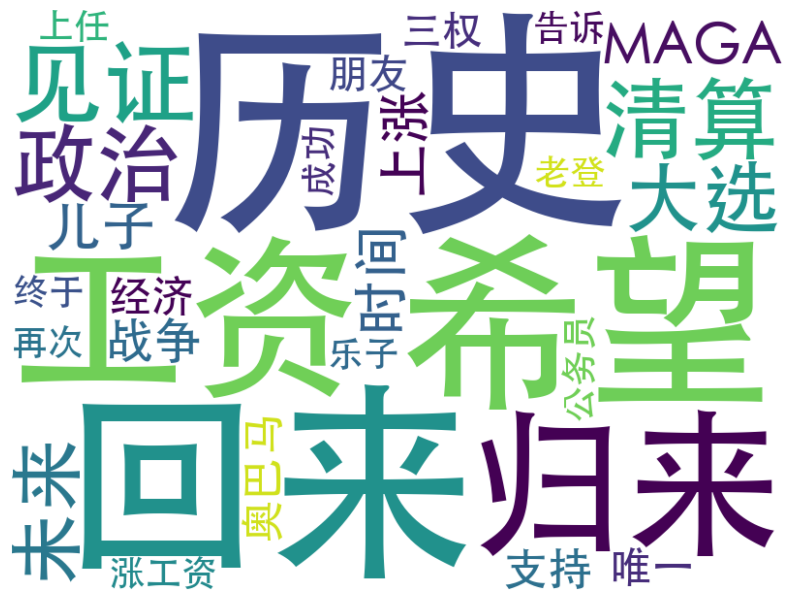

In [378]:
# Combine all comment texts into one string
text = ' '.join(top_level_comments_election['Comment Text'].dropna().astype(str))

# Perform Chinese word segmentation
words = jieba.lcut(text)

# Load Baidu stopwords
stopwords = set()
with open('baidu_stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        stopwords.add(line.strip())

# Filter out stopwords and very short words
filtered_words = [word for word in words if word not in stopwords and len(word) > 1]

# Calculate word frequencies
word_freq = Counter(filtered_words)

# Generate the Word Cloud based on word frequencies
wc = WordCloud(
    font_path='/System/Library/Fonts/STHeiti Medium.ttc',  # MacOS; for Windows use 'simhei.ttf'
    background_color='white',
    width=800,
    height=600,
    max_words=30
)

wc.generate_from_frequencies(word_freq)

# Show the Word Cloud
plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud of Comments')
plt.show()

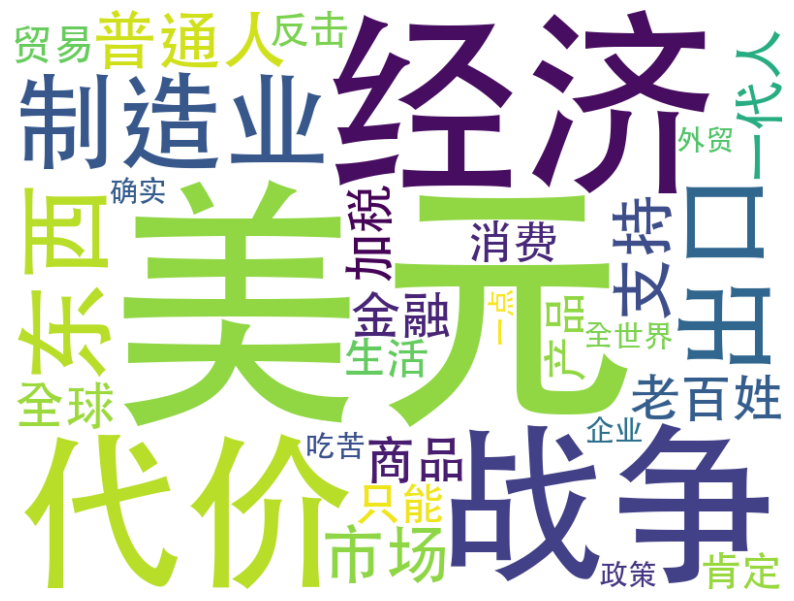

In [379]:
# Combine all comment texts into one string
text = ' '.join(top_level_comments_tariff['Comment Text'].dropna().astype(str))

# Perform Chinese word segmentation
words = jieba.lcut(text)

# Filter out stopwords and very short words
filtered_words = [word for word in words if word not in stopwords and len(word) > 1]

# Calculate word frequencies
word_freq = Counter(filtered_words)

# Generate the Word Cloud based on word frequencies
wc = WordCloud(
    font_path='/System/Library/Fonts/STHeiti Medium.ttc',  # MacOS; for Windows use 'simhei.ttf'
    background_color='white',
    width=800,
    height=600,
    max_words=30
)

wc.generate_from_frequencies(word_freq)

# Show the Word Cloud
plt.figure(figsize=(10, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud of Comments')
plt.show()